## 初始化HDMI
### 导入pynq基本的overlay

In [49]:
from pynq.overlays.base import BaseOverlay
from pynq.lib.video import *
base = BaseOverlay("base.bit")

### 初始化端口

In [50]:
# monitor configuration: 640*480 @ 60Hz
Mode = VideoMode(640,480,24)
hdmi_out = base.video.hdmi_out
hdmi_out.configure(Mode,PIXEL_BGR)
hdmi_out.start()

### 窗口长宽

In [51]:
# camera (input) configuration
frame_in_w = 640
frame_in_h = 480

### 初始化摄像头

In [52]:
import cv2
videoIn = cv2.VideoCapture(0)
videoIn.set(cv2.CAP_PROP_FRAME_WIDTH, frame_in_w);
videoIn.set(cv2.CAP_PROP_FRAME_HEIGHT, frame_in_h);
print("capture device is open: " + str(videoIn.isOpened()))

capture device is open: True


### 在HDMI中展示拍到的照片

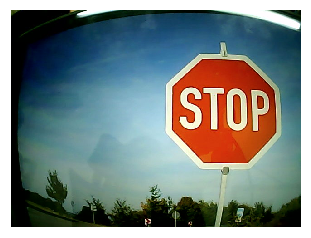

In [54]:
import matplotlib.pyplot as plt

ret, frame_vga= videoIn.read()


if (ret):
    outframe = hdmi_out.newframe()
    outframe[:] = frame_vga
    hdmi_out.writeframe(outframe)
else:
    raise RuntimeError("Error while reading from camera.")
frame_vga = cv2.cvtColor(frame_vga,cv2.COLOR_BGR2RGB)
plt.imshow(frame_vga)
plt.axis('off') 
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.savefig("test1.jpg")
plt.show()  

### 边缘检测

In [55]:
import time

num_frames = 20
readError = 0

start = time.time()
for i in range (num_frames):   
    # read next image
    ret, frame_vga = videoIn.read()
    if (ret):
        outframe = hdmi_out.newframe()
        laplacian_frame = cv2.Laplacian(frame_vga, cv2.CV_8U, dst=outframe)
        hdmi_out.writeframe(outframe)
    else:
        readError += 1
end = time.time()

print("Frames per second: " + str((num_frames-readError) / (end - start)))
print("Number of read errors: " + str(readError))

Frames per second: 9.324212540179131
Number of read errors: 0


### Canny边缘检测

In [56]:
num_frames = 20

Mode = VideoMode(640,480,8)
hdmi_out = base.video.hdmi_out
hdmi_out.configure(Mode,PIXEL_GRAY)
hdmi_out.start()

start = time.time()
for i in range (num_frames):
    # read next image
    ret, frame_webcam = videoIn.read()
    if (ret):
        outframe = hdmi_out.newframe()
        cv2.Canny(frame_webcam, 100, 110, edges=outframe)
        hdmi_out.writeframe(outframe)
    else:
        readError += 1
end = time.time()

print("Frames per second: " + str((num_frames-readError) / (end - start)))
print("Number of read errors: " + str(readError))

Frames per second: 9.171515128787144
Number of read errors: 0


### 展示结果

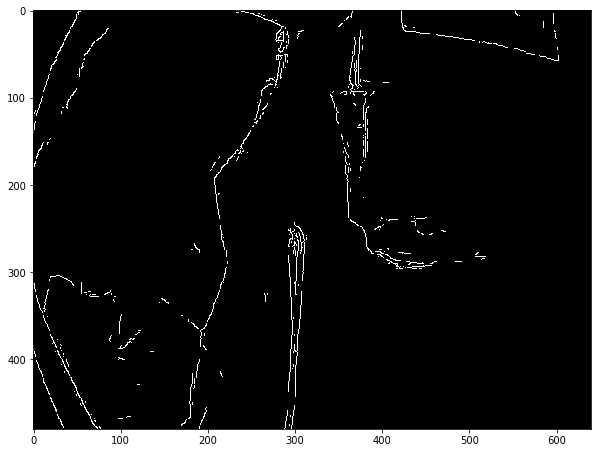

In [57]:
%matplotlib inline 
from matplotlib import pyplot as plt
import numpy as np

frame_canny = cv2.Canny(frame_webcam, 100, 110)
plt.figure(1, figsize=(10, 10))
frame_vga = np.zeros((480,640,3)).astype(np.uint8)
frame_vga[:,:,0] = frame_canny
frame_vga[:,:,1] = frame_canny
frame_vga[:,:,2] = frame_canny
plt.imshow(frame_vga)
plt.show()

### 将图片发至BNN检测的图片文件夹
### 释放HDMI端口

In [58]:
import shutil, os
shutil.move('/home/xilinx/jupyter_notebooks/base/video/test1.jpg', '/home/xilinx/jupyter_notebooks/bnn/pictures/road_signs/')
videoIn.release()
hdmi_out.stop()
del hdmi_out

In [59]:
import bnn #导入BNN
print(bnn.available_params(bnn.NETWORK_CNVW1A1))

classifier = bnn.CnvClassifier(bnn.NETWORK_CNVW1A1, 'road-signs', bnn.RUNTIME_HW)

['road-signs', 'streetview', 'cifar10']


### 读取要检测的图片

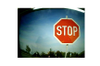

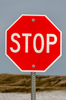

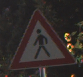

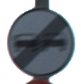

In [60]:
from PIL import Image
import numpy as np
from os import listdir
from os.path import isfile, join
from IPython.display import display

imgList = [f for f in listdir("/home/xilinx/jupyter_notebooks/bnn/pictures/road_signs/") if isfile(join("/home/xilinx/jupyter_notebooks/bnn/pictures/road_signs/", f))]

images = []
   
for imgFile in imgList:
	img = Image.open("/home/xilinx/jupyter_notebooks/bnn/pictures/road_signs/" + imgFile)
	images.append(img)    
	img.thumbnail((100, 100), Image.ANTIALIAS)
	display(img) 
  

### 分类分析

In [61]:
results = classifier.classify_images(images)
print("Identified classes: {0}".format(results))
for index in results:
    print("Identified class name: {0}".format((classifier.class_name(index))))

Inference took 3200.00 microseconds, 800.00 usec per image
Classification rate: 1250.00 images per second
Identified classes: [ 9 14 27 41]
Identified class name: No overtaking
Identified class name: Stop
Identified class name: Pedestrians in road ahead
Identified class name: End of no-overtaking zone


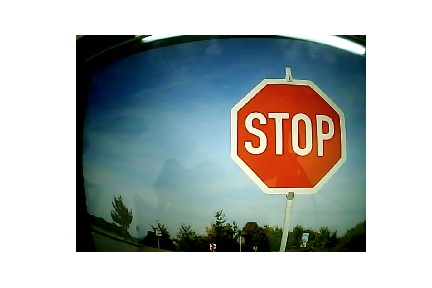

In [62]:
from PIL import Image
image_file = "/home/xilinx/jupyter_notebooks/bnn/pictures/road_signs/test1.jpg"
im = Image.open(image_file)
im

In [63]:
images = []
bounds = []
for s in [64,96]:
    stride = s // 4
    x_tiles = im.width // stride
    y_tiles = im.height // stride
    
    for j in range(y_tiles):
        for i in range(x_tiles):
            bound = (stride * i, stride * j, stride * i + s, stride * j + s)
            if bound[2] <= im.width and bound[3] < im.height:
                c = im.crop(bound)
                images.append(c)
                bounds.append(bound)

print(len(images))

456


### 目标检测

Inference took 151313.00 microseconds, 331.83 usec per image
Classification rate: 3013.62 images per second


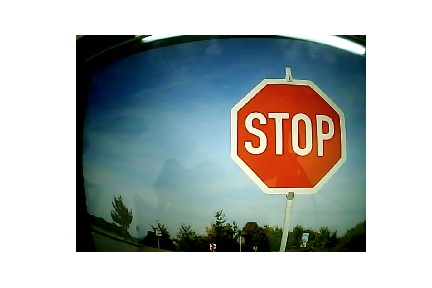

In [64]:
result = classifier.classify_images_details(images)
result=result.reshape(len(images),44)
from PIL import ImageDraw

draw = ImageDraw.Draw(im)
i=0
for image in images:
    if result[i][14] > 455:
        draw.rectangle(bounds[i], outline='red')
    i=i+1    
    
im

In [99]:
from pynq import Xlnk

xlnk = Xlnk();
xlnk.xlnk_reset()

In [100]:
from pynq import Overlay
from pynq import Xlnk
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
from time import time
xlnk = Xlnk()
overlay = Overlay('/home/xilinx/jupyter_notebooks/ORB_FPGA-master/ORB_FPGA/overlays/ORB_FPGA.bit')
dma_FAST = overlay.axi_dma_FAST
dma_Gaus = overlay.axi_dma_Gaus
dma_des = overlay.axi_dma_des_2Mem
dma_des.recvchannel.start()
dma_FAST.sendchannel.start()
dma_Gaus.sendchannel.start()

In [101]:
# import shutil, os
# shutil.move('/home/xilinx/jupyter_notebooks/bnn/pictures/road_signs/test1.jpg', '/home/xilinx/jupyter_notebooks/ORB_FPGA-master/pynq_notebook/test_data/')
# infile = '/home/xilinx/jupyter_notebooks/ORB_FPGA-master/pynq_notebook/test_data/test1.jpg'
# outfile = '/home/xilinx/jupyter_notebooks/ORB_FPGA-master/pynq_notebook/test_data/test1.jpg'
# im = Image.open(infile)
# (x,y) = im.size #read image size
# x_s = 640 #define standard width
# y_s = 480 #calc height based on standard width
# out = im.resize((x_s,y_s),Image.ANTIALIAS) #resize image with high-quality
# out.save(outfile)

img_ori = cv2.imread('/home/xilinx/jupyter_notebooks/ORB_FPGA-master/pynq_notebook/test_data/test1.jpg')

#img_ori = cv2.imread("/home/xilinx/jupyter_notebooks/bnn/pictures/road_signs/test1.jpg")
img_gray = cv2.cvtColor(img_ori,cv2.COLOR_BGR2GRAY)

#src_buf = xlnk.cma_array(shape=(1036*584,), dtype=np.uint8)
src_buf = xlnk.cma_array(shape=(640*480,), dtype=np.uint8)
view=np.frombuffer(src_buf,dtype = np.uint8,count = -1)
np.copyto(view,img_gray.ravel(),casting='same_kind')
des_buf = xlnk.cma_array(shape=(8192,10), dtype=np.int32)

### 特征提取

In [102]:
dma_des.recvchannel.transfer(des_buf)
dma_FAST.sendchannel.transfer(src_buf)
dma_Gaus.sendchannel.transfer(src_buf)
dma_Gaus.sendchannel.wait()
dma_FAST.sendchannel.wait()
dma_des.recvchannel.wait()
des_buf.flush()
bytes_read=dma_des.mmio.read(0x58)
featurePointsNum = int(bytes_read/40) - 1
print(str(featurePointsNum)+' feature points are detected')

0 feature points are detected


In [103]:
for i in range(2):
    posX = des_buf[i][8]
    posY = des_buf[i][9]
    print('descriptor: ')
    print(des_buf[i][0:7])
    print('\npositon:')
    print('x:'+str(posX)+'  y:'+str(posY)+'\n')

descriptor: 
[0 0 0 0 0 0 0]

positon:
x:4095  y:4095

descriptor: 
[0 0 0 0 0 0 0]

positon:
x:0  y:0



In [104]:
points = des_buf[0:(featurePointsNum-1)]
pos = (points[:,8:10]).copy()
posList=pos.tolist()
for i in posList:
    cv2.circle(img_ori,(i[0],i[1]),2,(0, 0, 213),-1)

### 展示结果

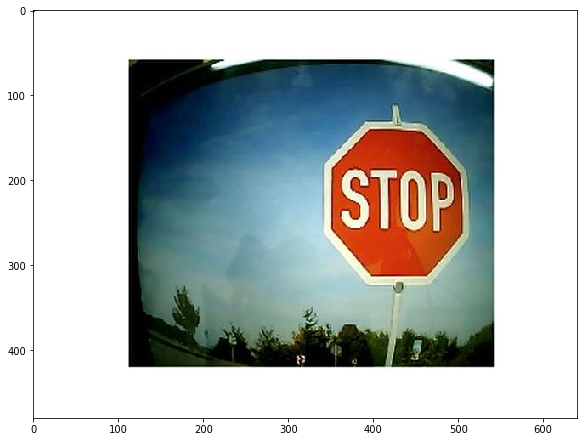

In [105]:
img_disp = cv2.cvtColor(img_ori,cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,7.5))
plt.imshow(img_disp)


### 释放缓存器

In [106]:
src_buf.freebuffer()
des_buf.freebuffer()

### 释放DMA信道

In [107]:
dma_des.recvchannel.stop()
dma_FAST.sendchannel.stop()
dma_Gaus.sendchannel.stop()